In [4]:
from gridworld.Gridworld import Gridworld

In [5]:
import numpy as np
import torch
from gridworld.Gridworld import Gridworld
import random
from matplotlib import pylab as plt

import torch
from torch import nn
from torch import optim

### 3.2 Navigating with Q-learning

In [14]:
l1 = n_pixels = 64
l2 = hidden_1 = 150
l3 = hidden_2 = 100
l4 = n_actions = 4

In [15]:
model = nn.Sequential(
    nn.Linear(n_pixels, hidden_1),
    nn.ReLU(),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, n_actions)
)

In [16]:
loss_func = nn.MSELoss()
learning_rate = 1e-3
optimizier = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
GAMMA = 0.9
EPSILON = 1.0

In [27]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

In [28]:
epochs = 1000
losses = []

In [29]:
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    
    noise = torch.randn(1, 64) / 10.0
    state = game.board.render_np().reshape(1, 64)
    state = torch.from_numpy(state).float() + noise
    
    in_progress = True
    while (in_progress is True):
        predicted_reward = model(state)
        if (random.random() < EPSILON) and 1 != 2:
            action_idx = torch.randint(0, 4, (1,)).item()
        else:
            action_idx = torch.argmax(predicted_reward).item()
        
        action = action_set[action_idx]
        game.makeMove(action)
        
        new_noise = torch.randn(1, 64) / 10.0
        new_state = game.board.render_np().reshape(1, 64)
        new_state = torch.from_numpy(new_state).float()
        new_state = new_state + new_noise
        
        reward = game.reward()
        reward = torch.tensor(reward).float()
        
        with torch.no_grad():
            next_predicted_reward = model(new_state.reshape(1, 64))
        
        max_predicted_next_reward = torch.max(next_predicted_reward)
        
        # if reward is -1, the game is still in progress => next reward is exists
        if reward == -1:
            # current reward and a discount of the maximum reward of the next state
            target_reward = reward + GAMMA * max_predicted_next_reward
        else:
            target_reward = reward
                
        # predicted reward given take a chosen action
        current_predicted_reward = predicted_reward.squeeze()[action_idx]
        loss = loss_func(current_predicted_reward, target_reward)
        losses.append(loss.item())
        
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()
        
        state = new_state
        
        # if reward is -1, the game is still in progress
        if reward != -1:
            in_progress = False
    
    if EPSILON > 0.1:
        EPSILON -= (1/epochs)

In [30]:
losses[:3]

[1.6990965604782104, 7.012789249420166, 3.1275393962860107]

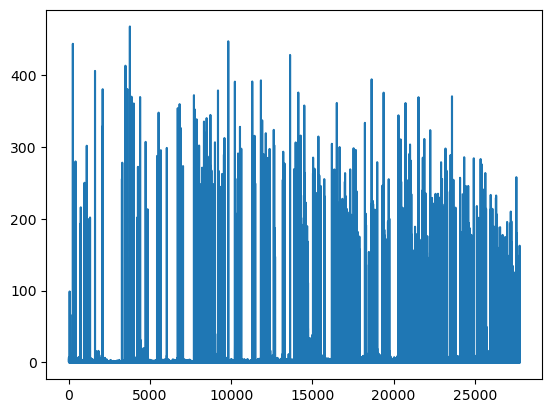

In [31]:
plt.plot(losses)
plt.show()

### 3.2 Preventing catastrophic forgetting: Experience replay

from collections import deque

In [66]:
import collections

In [71]:
EPOCHS = 250
losses = []

In [72]:
mem_size = 1000
batch_size = 200
replay = collections.deque(maxlen=mem_size)
max_moves = 50
h = 0

In [73]:
for i in range(EPOCHS):
    game = Gridworld(size=4, mode='ramdom')

    noise = torch.randn(1, 64) / 100.0    
    state = game.board.render_np().reshape(1, 64)
    state = torch.from_numpy(state)
    state = state + noise
    
    in_progress = True
    
    mov = 0
    
    while in_progress:
        mov += 1
        action_reward = model(state)
        
        if random.random() < EPSILON:
            action_idx = torch.randint(0, 4, (1,)).item()
        else:
            action_idx = torch.argmax(action_reward).item()
        
        action = action_set[action_idx]
        game.makeMove(action)
        
        noise = torch.randn(1, 64) / 100.0    
        new_state = game.board.render_np().reshape(1, 64)
        new_state = torch.from_numpy(new_state)
        new_state = new_state + noise
        
        reward = game.reward()
        done = True if reward > 0 else False
        
        exp = (state, action_idx, reward, new_state, done)
        replay.append(exp)
        
        state = new_state
        
        if len(replay) > batch_size:
            # select `batch_size` from `replay`
            mini_batch = random.sample(replay, batch_size)
            state_batch = torch.cat([state for (state, action_idx, reward, new_state, done) in mini_batch])
            action_batch = torch.tensor([action_idx for (state, action_idx, reward, new_state, done) in mini_batch])
            reward_batch = torch.tensor([reward for (state, action_idx, reward, new_state, done) in mini_batch])
            new_state_batch = torch.cat([new_state for (state, action_idx, reward, new_state, done) in mini_batch])
            done_batch = torch.tensor([done for (state, action_idx, reward, new_state, done) in mini_batch])
            
            action_reward_batch = model(state_batch)
            with torch.no_grad():
                next_action_reward_batch = model(new_state_batch)
            
            max_next_reward_batch = torch.max(next_action_reward_batch, dim=-1)[0]
            target_reward_batch = reward_batch + GAMMA * ((1-done_batch.int()) * max_next_reward_batch)
            
            # extract the corresponds reward of a batch of actions
            predicted_reward_batch = action_reward_batch.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()

            loss = loss_func(target_reward_batch, predicted_reward_batch)
            losses.append(loss.item())
            
            optimizier.zero_grad()
            loss.backward()
            optimizier.step()
        
        # if reward is 1 => game is still in progress
        if reward != -1 or mov > max_moves:
            in_progress = False
            mov = 0

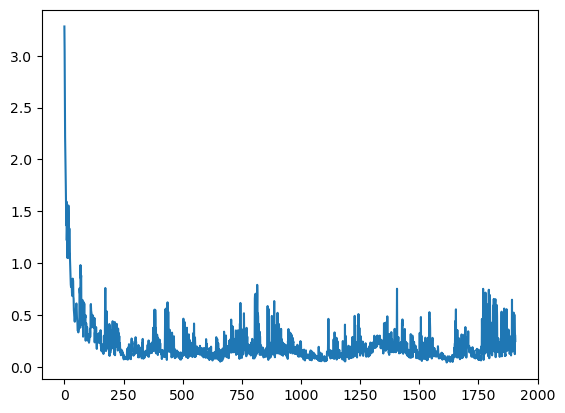

In [74]:
plt.plot(losses)
plt.show()

### 3.4 Improving stability with a target network

In [1]:
import copy

In [6]:
n_pixels = 64
hidden_1 = 150
hidden_2 = 100
n_actions = 4

In [8]:
regular_model = nn.Sequential(
    nn.Linear(n_pixels, hidden_1),
    nn.ReLU(),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, n_actions),
)

In [10]:
target_model = copy.deepcopy(regular_model)
target_model.load_state_dict(regular_model.state_dict())

<All keys matched successfully>

In [11]:
SYNC_FREQ = 50
LEARNING_RATE = 1e-3

In [12]:
loss_func = nn.MSELoss()
optimizier = optim.Adam(regular_model.parameters(), lr=LEARNING_RATE)

In [13]:
import collections

In [15]:
EPOCHS = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = collections.deque(maxlen = mem_size)
max_moves = 50
h = 0
SYNC_FREQ = 50
j = 0